# ADS proj -- School & Crime

## _PUMA level_

by: Emily Padvorac, Matt Dwyer, Rebecca Scheidegger, Dana Chermesh

_**NYU CUSP**, Fall 2017_

In [2]:
from __future__ import print_function, division
import sys
import os
import numpy as np
import pylab as pl
#importing pandas for reading and parsing of tabulated data
import pandas as pd
#importing geopandas read to plot geographical information
import geopandas as gpd
#importing fiona to handle geographical coordinates
import fiona
#import shapely to handle geographical shapes
import shapely
import json
import requests 
import urllib

import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style('whitegrid')
%pylab inline

import statsmodels.formula.api as smf
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [3]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/dcr346/PUIdata


## Read in School shapefile (points)

In [4]:
schoolshp = gpd.GeoDataFrame.from_file(PUIDATA +"/Public_Schools_Points_2011-2012A.shp")
#schoolshp.crs = from_epsg(2263) 
schoolshp.head()

,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,NY,11220,Jennifer Eusanio,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163)
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,NY,11226,ADRIENNE SPENCER,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498)
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,NY,11223,Janet Ndzibah,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244)
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,NY,11204,Denise Sandra Levinsky,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183)
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,NY,11223,KRISTINE MUSTILLO,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843)


In [5]:
schoolshp.dtypes

ATS_CODE       object
BORO           object
BORONUM       float64
LOC_CODE       object
SCHOOLNAME     object
SCH_TYPE       object
MANAGED_BY      int64
GEO_DISTRI      int64
ADMIN_DIST      int64
ADDRESS        object
STATE_CODE     object
ZIP             int64
PRINCIPAL      object
PRIN_PH        object
FAX            object
GRADES         object
City           object
geometry       object
dtype: object

In [6]:
schoolshp.shape

(1709, 18)

## Read in PUMA shapefile

In [7]:
url = 'https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data'

In [8]:
urllib.request.urlretrieve(url, "puma.gz")
os.system("unzip -d %s puma.zip"%(os.getenv('PUIDATA')))

2304

In [9]:
pumashp = gpd.GeoDataFrame.from_file(PUIDATA + '/geo_export_3ec730a2-fc45-4924-aa8f-a1d3f9b4c746.shp')
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


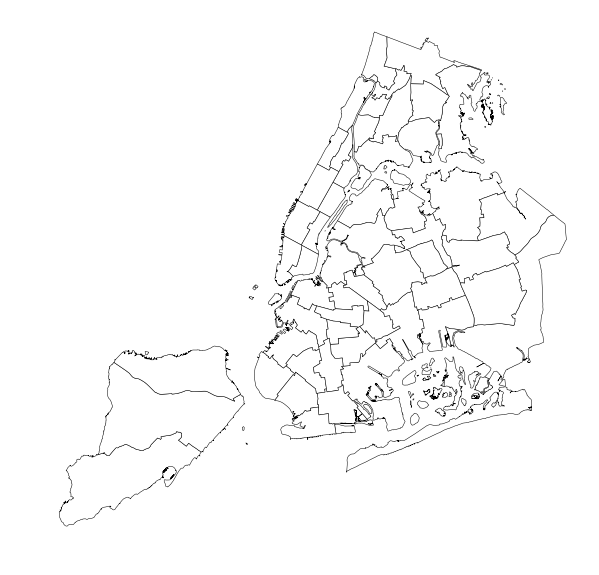

In [10]:
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=.5);

In [11]:
pumashp.shape

(55, 4)

## Read in School Progress Data

In [12]:
#schoolprog = pd.DataFrame.from_csv(PUIDATA + '/2007_-_2011_School_Progress_Report_Multi-year.csv')
#schoolprog.head()

In [13]:
schools2007 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/CA6CD49D-E595-4272-B594-385A6A3229A3/0/2007ProgressReportResults_011409.xls", skiprows=0)
schools2013 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/1550033E-3F15-4746-BD1A-DF3364721785/0/2012_2013_EMS_PR_Results_2014_04_24.xlsx", skiprows=1)

## Cleaning 2007 data

In [14]:
schools2007 = schools2007.dropna(0)
#schools2007 = schools2007.reset_index()

In [15]:
columns = (np.asarray(schools2007.iloc[:1,:]))
schools2007.columns = columns[0]
schools2007 =  schools2007.iloc[1:,:]

schools2007.head()

,DBN,DISTRICT,SCHOOL,SCHOOL SUPPORT ORGANIZATION/NETWORK,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,GRADE,OVERALL SCORE,ENVIRONMENT CATEGORY SCORE,PERFORMANCE CATEGORY SCORE,PROGRESS CATEGORY SCORE,ADDITIONAL CREDIT,QUALITY REVIEW SCORE
NaN,01M015,01,PS 015 ROBERTO CLEMENTE,ICI15,ESMS,Elementary School,75.6,B,52.31,0.278,0.231,0.694,3,Undeveloped
NaN,01M019,01,PS 019 ASHER LEVY,ESO1,ESMS,Elementary School,59.25,B,51.24,0.51,0.466,0.511,1.5,Proficient
NaN,01M020,01,PS 020 ANNA SILVER,ICI15,ESMS,Elementary School,69.78,B,52.59,0.568,0.682,0.402,1.5,Well-Developed
NaN,01M034,01,PS 034 FRANKLIN D ROOSEVELT,ICI15,ESMS,K-8 School,71.9,C,47.02,0.409,0.366,0.53,0.75,Proficient
NaN,01M063,01,PS 063 WILLIAM MCKINLEY,ICI15,ESMS,Elementary School,62.17,C,44.66,0.199,0.511,0.479,0,Proficient


In [16]:
schools2007['Rating'] = schools2007['GRADE'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})

In [17]:
schools2007 = schools2007[['DBN','SCHOOL','SCHOOL LEVEL*','Rating']]
schools2007.head()

,DBN,SCHOOL,SCHOOL LEVEL*,Rating
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [18]:
schools2007.columns = ['DBN','SchoolName','SchoolType','Rating']
schools2007.head()

,DBN,SchoolName,SchoolType,Rating
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [19]:
schools2007['DBN'] = schools2007['DBN'].str[2:]
schools2007.head()

,DBN,SchoolName,SchoolType,Rating
NaN,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [20]:
schools2007.shape

(1224, 4)

## Cleaning 2013 data

In [21]:
schools2013['Rating'] = schools2013['Overall Grade'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})

In [22]:
schools2013 = schools2013[['DBN','School Name','School Type','Rating']]
schools2013.columns = ['DBN','SchoolName','SchoolType','Rating']
schools2013['DBN'] = schools2013['DBN'].str[2:]
schools2013.head()

,DBN,SchoolName,SchoolType,Rating
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0
1,M019,P.S. 019 Asher Levy,Elementary,5.0
2,M020,P.S. 020 Anna Silver,Elementary,4.0
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0
4,M063,The STAR Academy - P.S.63,Elementary,3.0


In [23]:
schools2013.shape

(1198, 4)

## Merge School scores w School shp

## 2007

In [24]:
schools2007 = schools2007.merge(schoolshp, left_on='DBN', right_on='LOC_CODE')
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,...,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,01M015,M,1.0,M015,P.S. 015 ROBERTO CLEMENTE,Elementary,...,1,333 EAST 4 STREET,NY,10009,IRENE SANCHEZ,212-228-8730,212-477-0931,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,01M019,M,1.0,M019,P.S. 019 ASHER LEVY,Elementary,...,1,185 1 AVENUE,NY,10003,JACQUELINE FLANAGAN,212-533-5340,212-673-1477,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,01M020,M,1.0,M020,P.S. 020 ANNA SILVER,Elementary,...,1,166 ESSEX STREET,NY,10002,JAMES LEE,212-254-9577,212-254-3526,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,01M034,M,1.0,M034,P.S. 034 FRANKLIN D. ROOSEVELT,K-8,...,1,730 EAST 12 STREET,NY,10009,JOYCE STALLINGS HARTE,212-228-4433,212-353-1973,"PK,0K,01,02,03,04,05,06,07,08,SE",MANHATTAN,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,01M063,M,1.0,M063,P.S. 063 WILLIAM MCKINLEY,Elementary,...,1,121 EAST 3 STREET,NY,10009,DARLENE DESPEIGNES,212-674-3180,212-420-9018,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988036.345197865 203208.4555002286)


In [25]:
schools2007.shape

(1201, 22)

In [26]:
schools2007.columns

Index(['DBN', 'SchoolName', 'SchoolType', 'Rating', 'ATS_CODE', 'BORO',
       'BORONUM', 'LOC_CODE', 'SCHOOLNAME', 'SCH_TYPE', 'MANAGED_BY',
       'GEO_DISTRI', 'ADMIN_DIST', 'ADDRESS', 'STATE_CODE', 'ZIP', 'PRINCIPAL',
       'PRIN_PH', 'FAX', 'GRADES', 'City', 'geometry'],
      dtype='object')

In [27]:
schools2007 =  schools2007[['DBN','SchoolName','SchoolType','Rating', 'BORO', 'ZIP','geometry']]
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [28]:
schools2007.to_csv('schools2007.csv')

## 2013

In [29]:
schools2013 = schools2013.merge(schoolshp, left_on='DBN', right_on='LOC_CODE')
schools2013.head(3)

,DBN,SchoolName,SchoolType,Rating,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,...,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,01M015,M,1.0,M015,P.S. 015 ROBERTO CLEMENTE,Elementary,...,1,333 EAST 4 STREET,NY,10009,IRENE SANCHEZ,212-228-8730,212-477-0931,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,01M019,M,1.0,M019,P.S. 019 ASHER LEVY,Elementary,...,1,185 1 AVENUE,NY,10003,JACQUELINE FLANAGAN,212-533-5340,212-673-1477,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,01M020,M,1.0,M020,P.S. 020 ANNA SILVER,Elementary,...,1,166 ESSEX STREET,NY,10002,JAMES LEE,212-254-9577,212-254-3526,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988025.1479657721 202056.5849334946)


In [30]:
schools2013.shape

(1181, 22)

In [31]:
schools2013 =  schools2013[['DBN','SchoolName','SchoolType','Rating', 'BORO', 'ZIP','geometry']]
schools2013.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,The STAR Academy - P.S.63,Elementary,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [32]:
schools2013.to_csv('schools2013.csv')

# Spatial Join (.sjoin) with PUMA shp (point+polygons)

## 2007

In [33]:
type(schools2007)

pandas.core.frame.DataFrame

In [34]:
crs = {'init': 'epsg:2263'}
schools2007 = gpd.GeoDataFrame(schools2007, crs=crs, geometry=schools2007.geometry)
type(schools2007)

geopandas.geodataframe.GeoDataFrame

In [35]:
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [36]:
schools2007.crs

{'init': 'epsg:2263'}

In [37]:
pumashp.crs

{'init': 'epsg:4326'}

In [38]:
pumashp = pumashp.to_crs({'init': 'epsg:2263'})
pumashp.crs

{'init': 'epsg:2263'}

In [39]:
schools2007g = gpd.sjoin(schools2007, pumashp, how='inner', op='within')
schools2007g.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry,index_right,puma,shape_leng,shape_area
396,X307,EAMES PLACE (P.S.307),Elementary School,5.0,X,10468,POINT (1011441.883968057 255954.5619534563),0,3701,53227.144376,9.792852e+07
401,X340,PS 340,Elementary School,4.0,X,10468,POINT (1012674.011965437 255963.4726108323),0,3701,53227.144376,9.792852e+07
372,X086,PS 086 KINGSBRIDGE HEIGHTS,Elementary School,5.0,X,10468,POINT (1012385.25224769 256185.0749038415),0,3701,53227.144376,9.792852e+07
402,X342,INTERNATIONAL SCHOOL OF LIBERAL ARTS,Middle School,4.0,X,10468,POINT (1012546.720579609 256392.6970082848),0,3701,53227.144376,9.792852e+07
425,X549,DISCOVERY HIGH SCHOOL,High School,4.0,X,10468,POINT (1012755.37051009 256396.3899274084),0,3701,53227.144376,9.792852e+07


In [40]:
schools2007g.shape

(1201, 11)

In [41]:
schools2007g = schools2007g.groupby([schools2007g['puma']]).mean()
schools2007g = schools2007g[['Rating']]
#schools2007g['Rating'] = schools2007g['Rating'].str[:4]
schools2007g.columns = ['Rating07']
schools2007g.head()

,Rating07
puma,
3701,4.192308
3702,3.555556
3703,3.714286
3704,3.800000
3705,3.569231


## 2013

In [42]:
crs = {'init': 'epsg:2263'}
schools2013 = gpd.GeoDataFrame(schools2013, crs=crs, geometry=schools2013.geometry)
type(schools2013)

geopandas.geodataframe.GeoDataFrame

In [43]:
schools2013.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,The STAR Academy - P.S.63,Elementary,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [44]:
schools2013g = gpd.sjoin(schools2013, pumashp, how='inner', op='within')
schools2013g.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry,index_right,puma,shape_leng,shape_area
341,X307,Luisa Pineiro Fuentes School of Science and Di...,Elementary,5.0,X,10468,POINT (1011441.883968057 255954.5619534563),0,3701,53227.144376,9.792852e+07
346,X340,P.S. 340,Elementary,5.0,X,10468,POINT (1012674.011965437 255963.4726108323),0,3701,53227.144376,9.792852e+07
321,X086,P.S. 086 Kingsbridge Heights,Elementary,5.0,X,10468,POINT (1012385.25224769 256185.0749038415),0,3701,53227.144376,9.792852e+07
347,X342,International School for Liberal Arts,Middle,5.0,X,10468,POINT (1012546.720579609 256392.6970082848),0,3701,53227.144376,9.792852e+07
349,X360,P.S. 360,Elementary,3.0,X,10463,POINT (1011283.377664369 257987.5970700345),0,3701,53227.144376,9.792852e+07


In [45]:
schools2013g = schools2013g.groupby([schools2013g['puma']]).mean()
schools2013g = schools2013g[['Rating']]
schools2013g.columns = ['Rating13']
schools2013g.head()

,Rating13
puma,
3701,4.357143
3702,3.166667
3703,3.529412
3704,3.692308
3705,3.727273


## Merging two dataframes of 2007 & 2013, than merging with PUMA GeoDataFrame again

In [46]:
# merge 07 + 13 

schoolspuma = schools2007g.merge(schools2013g, left_index=True, right_index=True)
schoolspuma['RatingChange'] = schoolspuma['Rating13'] / schoolspuma['Rating07'] * 100
schoolspuma.head()

,Rating07,Rating13,RatingChange
puma,,,
3701,4.192308,4.357143,103.931848
3702,3.555556,3.166667,89.062500
3703,3.714286,3.529412,95.022624
3704,3.800000,3.692308,97.165992
3705,3.569231,3.727273,104.427900


In [47]:
# merge with puma shp

schoolspuma = schoolspuma.merge(pumashp, left_index=True, right_on='puma')
schoolspuma.head()

,Rating07,Rating13,RatingChange,puma,shape_leng,shape_area,geometry
index_right,,,,,,,
0,4.192308,4.357143,103.931848,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,..."
1,3.555556,3.166667,89.062500,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,..."
2,3.714286,3.529412,95.022624,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...
3,3.800000,3.692308,97.165992,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,..."
4,3.569231,3.727273,104.427900,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,..."


In [48]:
schoolspuma.dtypes

Rating07        float64
Rating13        float64
RatingChange    float64
puma             object
shape_leng      float64
shape_area      float64
geometry         object
dtype: object

In [49]:
schoolspuma['puma'] = schoolspuma['puma'].astype(int)

In [50]:
crs = {'init': 'epsg:2263'}
geoschoolspuma = gpd.GeoDataFrame(schoolspuma, crs=crs, geometry=schoolspuma.geometry)

In [51]:
geoschoolspuma.to_csv('schoolspuma.csv')

# Plot School Ratings by PUMA

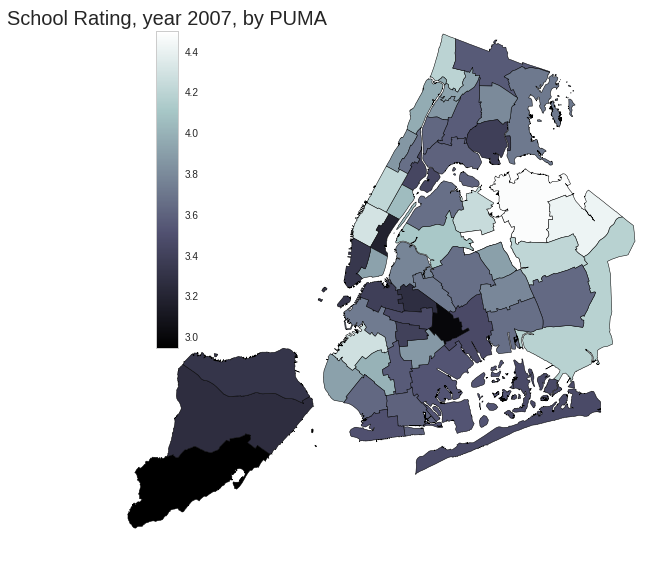

In [52]:
# Rating 07

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolspuma, column='Rating07', cmap='bone', k=7, edgecolor='k', lw=.5, ax=ax)
plt.title("School Rating, year 2007, by PUMA", fontsize=20);

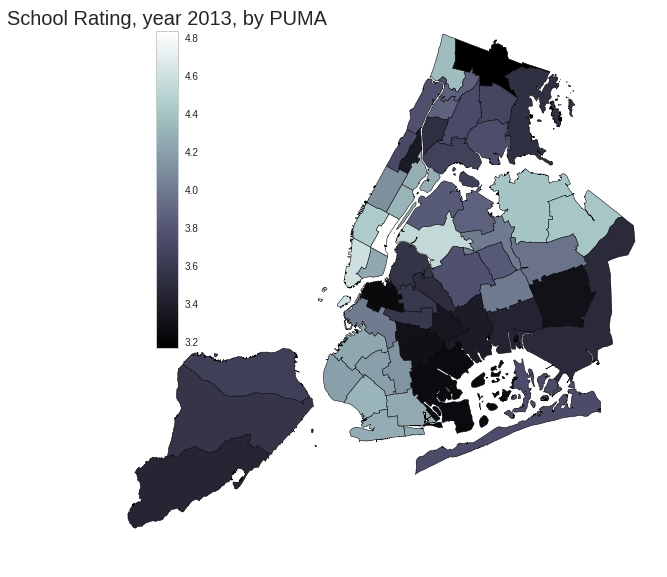

In [53]:
# Rating 13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolspuma, column='Rating13', cmap='bone', k=7, edgecolor='k', lw=.5, ax=ax)
plt.title("School Rating, year 2013, by PUMA", fontsize=20);

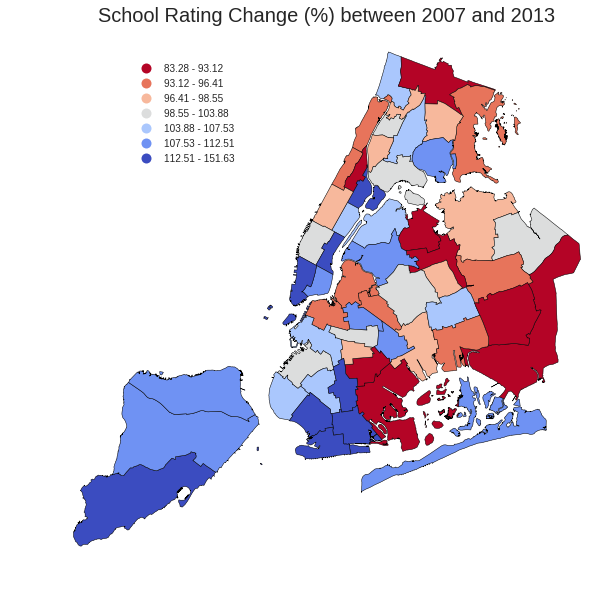

In [54]:
# change 07-13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(geoschoolspuma, column='RatingChange', cmap='coolwarm_r', scheme='Quantiles', k=7, edgecolor='k', lw=.5, ax=ax);
plt.title("School Rating Change (%) between 2007 and 2013", fontsize=20);

# Reading in Crime Data

In [55]:
crime07 = pd.read_csv('finalcrime07.csv')
crime07 = crime07.drop('Unnamed: 0',axis=1)
crime07.head()

,puma,all_crimes07,theft_crimes07,assault_crimes07,child_crimes07,drug_crimes07
0,3701,5479,1725,443,1,285
1,3702,8249,1731,741,3,1269
2,3703,5524,1548,405,1,225
3,3704,7282,2186,592,4,261
4,3705,16566,4119,2072,7,1858


In [56]:
crime13 = pd.read_csv('final13.csv')
crime13 = crime13.drop('Unnamed: 0',axis=1)
crime13.head()

,puma,all_crimes13,assault13,child13,drug13,murder13,thieving13
0,3701,4443,427,1,377,2,1506
1,3702,8049,1065,4,494,10,2214
2,3703,4799,448,1,215,4,1567
3,3704,6489,694,0,424,2,1884
4,3705,14581,2080,3,1662,13,3759


In [57]:
# merge crime 07 and 13

crime = crime07.merge(crime13, on='puma')
crime.head()

,puma,all_crimes07,theft_crimes07,assault_crimes07,child_crimes07,drug_crimes07,all_crimes13,assault13,child13,drug13,murder13,thieving13
0,3701,5479,1725,443,1,285,4443,427,1,377,2,1506
1,3702,8249,1731,741,3,1269,8049,1065,4,494,10,2214
2,3703,5524,1548,405,1,225,4799,448,1,215,4,1567
3,3704,7282,2186,592,4,261,6489,694,0,424,2,1884
4,3705,16566,4119,2072,7,1858,14581,2080,3,1662,13,3759


In [58]:
crime.puma.dtypes

dtype('int64')

## Merging Crime with Schools, than merging with PUMA GeoDataFrame again

In [59]:
# merge crime and schools

crimeschools = schoolspuma.merge(crime,  on='puma')
crimeschools.head()

,Rating07,Rating13,RatingChange,puma,shape_leng,shape_area,geometry,all_crimes07,theft_crimes07,assault_crimes07,child_crimes07,drug_crimes07,all_crimes13,assault13,child13,drug13,murder13,thieving13
0,4.192308,4.357143,103.931848,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",5479,1725,443,1,285,4443,427,1,377,2,1506
1,3.555556,3.166667,89.062500,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",8249,1731,741,3,1269,8049,1065,4,494,10,2214
2,3.714286,3.529412,95.022624,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,5524,1548,405,1,225,4799,448,1,215,4,1567
3,3.800000,3.692308,97.165992,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",7282,2186,592,4,261,6489,694,0,424,2,1884
4,3.569231,3.727273,104.427900,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",16566,4119,2072,7,1858,14581,2080,3,1662,13,3759


In [60]:
pumashp.dtypes

puma           object
shape_leng    float64
shape_area    float64
geometry       object
dtype: object

In [61]:
pumashp['puma'] = pumashp['puma'].astype(int)

In [62]:
# merge with puma shp

crimeschools = crimeschools.merge(pumashp, on='puma')
crimeschools = crimeschools.set_index('puma')
crimeschools.head()

,Rating07,Rating13,RatingChange,shape_leng_x,shape_area_x,geometry_x,all_crimes07,theft_crimes07,assault_crimes07,child_crimes07,drug_crimes07,all_crimes13,assault13,child13,drug13,murder13,thieving13,shape_leng_y,shape_area_y,geometry_y
puma,,,,,,,,,,,,,,,,,,,,
3701,4.192308,4.357143,103.931848,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",5479,1725,443,1,285,4443,427,1,377,2,1506,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,..."
3702,3.555556,3.166667,89.062500,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",8249,1731,741,3,1269,8049,1065,4,494,10,2214,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,..."
3703,3.714286,3.529412,95.022624,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,5524,1548,405,1,225,4799,448,1,215,4,1567,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...
3704,3.800000,3.692308,97.165992,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",7282,2186,592,4,261,6489,694,0,424,2,1884,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,..."
3705,3.569231,3.727273,104.427900,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",16566,4119,2072,7,1858,14581,2080,3,1662,13,3759,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,..."


In [63]:
crimeschools['crimechange'] = crimeschools['all_crimes13'] / crimeschools['all_crimes07']

In [64]:
crimeschools = gpd.GeoDataFrame(crimeschools, crs=crs, geometry=crimeschools.geometry_x)
crimeschools = crimeschools.drop('geometry_x',axis=1)
crimeschools = crimeschools.drop('geometry_y',axis=1)
crimeschools.head()

,Rating07,Rating13,RatingChange,shape_leng_x,shape_area_x,all_crimes07,theft_crimes07,assault_crimes07,child_crimes07,drug_crimes07,all_crimes13,assault13,child13,drug13,murder13,thieving13,shape_leng_y,shape_area_y,crimechange,geometry
puma,,,,,,,,,,,,,,,,,,,,
3701,4.192308,4.357143,103.931848,53227.144376,9.792852e+07,5479,1725,443,1,285,4443,427,1,377,2,1506,53227.144376,9.792852e+07,0.810914,"POLYGON ((1012885.033996583 268830.4841918442,..."
3702,3.555556,3.166667,89.062500,106050.008344,1.889860e+08,8249,1731,741,3,1269,8049,1065,4,494,10,2214,106050.008344,1.889860e+08,0.975755,"POLYGON ((1021632.335632326 267934.4393920284,..."
3703,3.714286,3.529412,95.022624,304875.033427,2.670770e+08,5524,1548,405,1,225,4799,448,1,215,4,1567,304875.033427,2.670770e+08,0.868755,(POLYGON ((1042822.450195312 243439.8142089319...
3704,3.800000,3.692308,97.165992,47970.900868,1.062129e+08,7282,2186,592,4,261,6489,694,0,424,2,1884,47970.900868,1.062129e+08,0.891101,"POLYGON ((1026308.769592285 256767.6972045382,..."
3705,3.569231,3.727273,104.427900,68593.066759,1.224946e+08,16566,4119,2072,7,1858,14581,2080,3,1662,13,3759,68593.066759,1.224946e+08,0.880176,"POLYGON ((1020080.524597168 255041.8771972096,..."


In [65]:
crimeschools.to_csv('crimeschools.csv')

# Plotting Crime Rates and School Performance Rates

(None,
 <matplotlib.legend.Legend at 0x7fa59e66b0f0>)

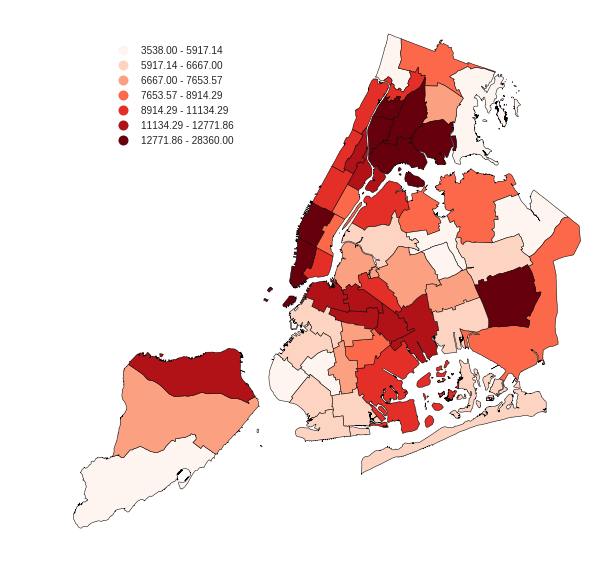

In [66]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(crimeschools, column='all_crimes07', cmap='Reds', scheme='Quantiles', k=7, edgecolor='k', lw=.5, ax=ax)

#x = schools2007g.longitude;
#y = schools2007g.latitude;
#c = schools2007g.Rating
#scatter(x,y,4,c, cmap='Reds')

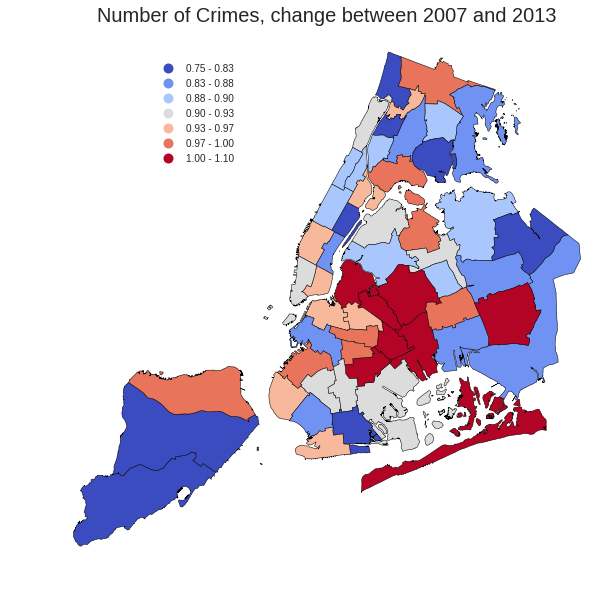

In [67]:
# change 07-13

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(crimeschools, column='crimechange', cmap='coolwarm', scheme='Quantiles', k=7, edgecolor='k', lw=.5, ax=ax);
plt.title("Number of Crimes, change between 2007 and 2013", fontsize=20);

In [68]:
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
index_left,,,,,,,
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


# OLS regression

## 1. Linear regression of crime rates and school rating

In [69]:
lm1 = smf.ols(formula = 'Rating07 ~ all_crimes07', data = crimeschools).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Rating07   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.587
Date:                Sun, 10 Dec 2017   Prob (F-statistic):              0.213
Time:                        11:31:13   Log-Likelihood:                -21.005
No. Observations:                  55   AIC:                             46.01
Df Residuals:                      53   BIC:                             50.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        3.8773      0.118     32.744      0.000         3.640     4.115
all_crimes07 -1.452e-05   1.15e-05     -1.260      0.213     -3.76e-05   8.6e-06
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   1.163
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.459
Skew:                           0.212   Prob(JB):                        0.795
Kurtosis:                       2.855   Cond. No.                     2.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

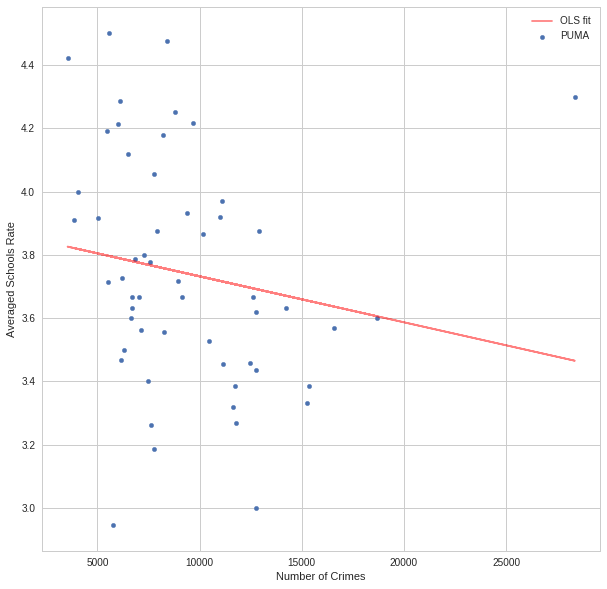

In [70]:
fig = pl.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.scatter(crimeschools['all_crimes07'], crimeschools['Rating07'], label = "PUMA", s = 20)
ax.plot(crimeschools['all_crimes07'], lm1.predict(), label = 'OLS fit', color = 'r', alpha=0.5)
ax.set_xlabel('Number of Crimes')
ax.set_ylabel('Averaged Schools Rate')
ax.legend()

In [71]:
# OLS regression for only drug crimes

lm2 = smf.ols(formula = 'Rating07 ~ drug_crimes07', data = crimeschools).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Rating07   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     6.343
Date:                Sun, 10 Dec 2017   Prob (F-statistic):             0.0148
Time:                        11:31:13   Log-Likelihood:                -18.708
No. Observations:                  55   AIC:                             41.42
Df Residuals:                      53   BIC:                             45.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         3.8522      0.064     60.025      0.000         3.723     3.981
drug_crimes07    -0.0002   6.21e-05     -2.518      0.015        -0.000 -3.19e-05
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   1.128
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.363
Skew:                          -0.095   Prob(JB):                        0.834
Kurtosis:                       2.650   Cond. No.                     1.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
# OLS regression for change (%) in school rates and crimes

lm3 = smf.ols(formula = 'RatingChange ~ crimechange', data = crimeschools).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RatingChange   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.891
Date:                Sun, 10 Dec 2017   Prob (F-statistic):             0.0949
Time:                        11:31:13   Log-Likelihood:                -214.12
No. Observations:                  55   AIC:                             432.2
Df Residuals:                      53   BIC:                             436.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     134.9969     18.672      7.230      0.000        97.545   172.449
crimechange   -34.4277     20.249     -1.700      0.095       -75.042     6.186
==============================================================================
Omnibus:                       25.702   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.337
Skew:                           1.484   Prob(JB):                     5.26e-11
Kurtosis:                       6.443   Cond. No.                         22.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""